In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import pandas as pd
import zarr
import gcsfs
import requests
import warnings
warnings.filterwarnings("ignore")
##### Cloud data
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
gcs = gcsfs.GCSFileSystem(token='anon')
df  = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [2]:
def read_data(im):
    im=im
    ie='abrupt-4xCO2'
    iv='tos'
    cat = col.search(
        source_id=im,
        experiment_id=ie,
        variable_id=iv,
        table_id='Omon',
        grid_label='gn',
        member_id='r1i1p1f1',
    )
    dset_dict = cat.to_dataset_dict(zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True})
    ds = dset_dict[list(dset_dict.keys())[0]].isel(time=0)
    return ds

In [3]:
im = 'CanESM5'
ds = read_data(im).squeeze()
grid_in   = {'lon': ds['tos']['longitude'], 'lat': ds['tos']['latitude']} 
grid_out  = {'lon': np.linspace(0, 359, 360), 'lat': np.linspace(-89.5, 89.5, 180)}
regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True, ignore_degenerate=True)
tos_regrid           = regridder(ds['tos'])
tos_regrid_ignore_NA = regridder(ds['tos'], skipna=True)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


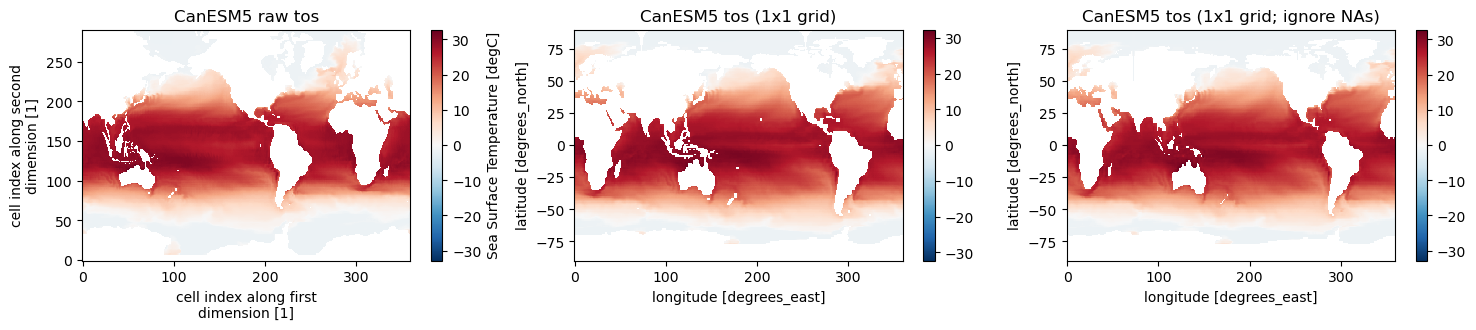

In [4]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(18,3))
axs      = axs.flatten()
ds['tos'].plot(ax=axs[0])            ; axs[0].set_title(im+' raw tos');
tos_regrid.plot(ax=axs[1])           ; axs[1].set_title(im+' tos (1x1 grid)');
tos_regrid_ignore_NA.plot(ax=axs[2]) ; axs[2].set_title(im+' tos (1x1 grid; ignore NAs)');

### Special case: IPSL-CM6A-LR
If we wish to regrid using the full data of IPSL model, we will encounter the issue of NAs along 72.5E. The issue appears to stem from the weird longitude near 72.5E in this model (which is the longitude edge). To circumvent this, I think we need to either skip the first column (`lon[0]`) or the last column (`lon[-1]`), so that longitude can be "monotonic" across the edges. More info below:

In [5]:
im = 'IPSL-CM6A-LR'
ds = read_data(im).squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
grid_in   = {'lon': ds['tos']['nav_lon'], 'lat': ds['tos']['nav_lat']} 
grid_out  = {'lon': np.linspace(0.5, 359.5, 360), 'lat': np.linspace(-89.5, 89.5, 180)}
regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True, ignore_degenerate=True)
tos_regrid           = regridder(ds['tos'])
tos_regrid_ignore_NA = regridder(ds['tos'], skipna=True)

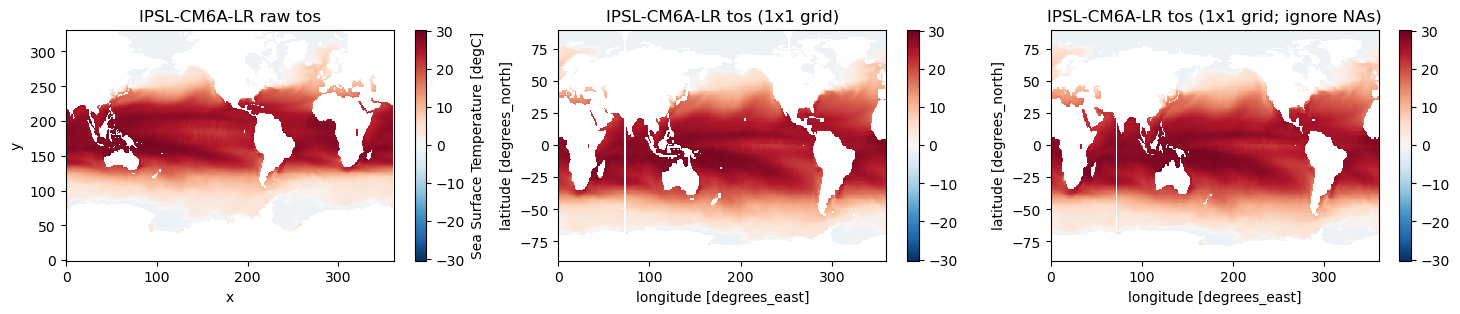

In [7]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(18,3))
axs      = axs.flatten()
ds['tos'].plot(ax=axs[0])            ; axs[0].set_title(im+' raw tos');
tos_regrid.plot(ax=axs[1])           ; axs[1].set_title(im+' tos (1x1 grid)');
tos_regrid_ignore_NA.plot(ax=axs[2]) ; axs[2].set_title(im+' tos (1x1 grid; ignore NAs)');

In [8]:
grid_in   = {'lon': ds['tos']['nav_lon'][:,1:], 'lat': ds['tos']['nav_lat'][:,1:]} 
grid_out  = {'lon': np.linspace(0.5, 359.5, 360), 'lat': np.linspace(-89.5, 89.5, 180)}
regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True, ignore_degenerate=True)
tos_regrid           = regridder(ds['tos'][:,1:])
tos_regrid_ignore_NA = regridder(ds['tos'][:,1:], skipna=True)

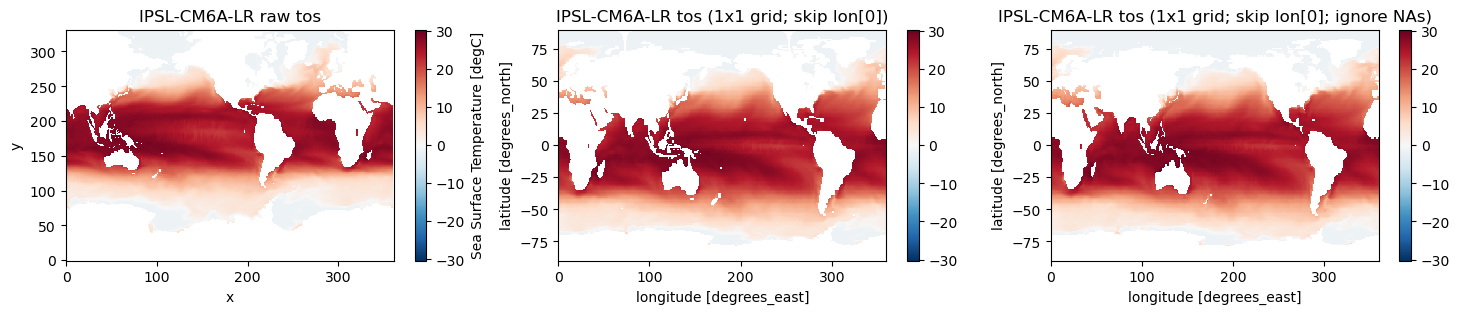

In [9]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(18,3))
axs      = axs.flatten()
ds['tos'].plot(ax=axs[0])            ; axs[0].set_title(im+' raw tos');
tos_regrid.plot(ax=axs[1])           ; axs[1].set_title(im+' tos (1x1 grid; skip lon[0])');
tos_regrid_ignore_NA.plot(ax=axs[2]) ; axs[2].set_title(im+' tos (1x1 grid; skip lon[0]; ignore NAs)');

In [10]:
ds['tos']['nav_lon'][100,:].values # IPSL weird longitude
# I think we should skip the first or the last one to make it monotonic through the edge, what do you think?

array([  72.5,   73.5,   74.5,   75.5,   76.5,   77.5,   78.5,   79.5,
         80.5,   81.5,   82.5,   83.5,   84.5,   85.5,   86.5,   87.5,
         88.5,   89.5,   90.5,   91.5,   92.5,   93.5,   94.5,   95.5,
         96.5,   97.5,   98.5,   99.5,  100.5,  101.5,  102.5,  103.5,
        104.5,  105.5,  106.5,  107.5,  108.5,  109.5,  110.5,  111.5,
        112.5,  113.5,  114.5,  115.5,  116.5,  117.5,  118.5,  119.5,
        120.5,  121.5,  122.5,  123.5,  124.5,  125.5,  126.5,  127.5,
        128.5,  129.5,  130.5,  131.5,  132.5,  133.5,  134.5,  135.5,
        136.5,  137.5,  138.5,  139.5,  140.5,  141.5,  142.5,  143.5,
        144.5,  145.5,  146.5,  147.5,  148.5,  149.5,  150.5,  151.5,
        152.5,  153.5,  154.5,  155.5,  156.5,  157.5,  158.5,  159.5,
        160.5,  161.5,  162.5,  163.5,  164.5,  165.5,  166.5,  167.5,
        168.5,  169.5,  170.5,  171.5,  172.5,  173.5,  174.5,  175.5,
        176.5,  177.5,  178.5,  179.5, -179.5, -178.5, -177.5, -176.5,
      